In [8]:
import torch

In [9]:
torch.cuda.is_available()

False

/home/student/Desktop/220962029/venv/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0/500], Loss: 0.4226
Epoch [50/500], Loss: 0.1355
Epoch [100/500], Loss: 0.0418
Epoch [150/500], Loss: 0.0181
Epoch [200/500], Loss: 0.0148
Epoch [250/500], Loss: 0.0136
Epoch [300/500], Loss: 0.0062
Epoch [350/500], Loss: 0.0030
Epoch [400/500], Loss: 0.0006
Epoch [450/500], Loss: 0.0011


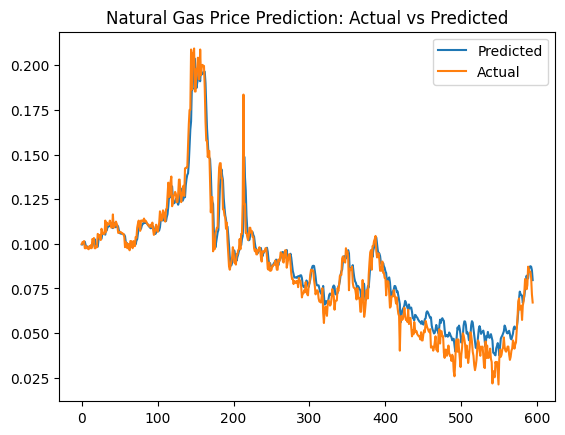

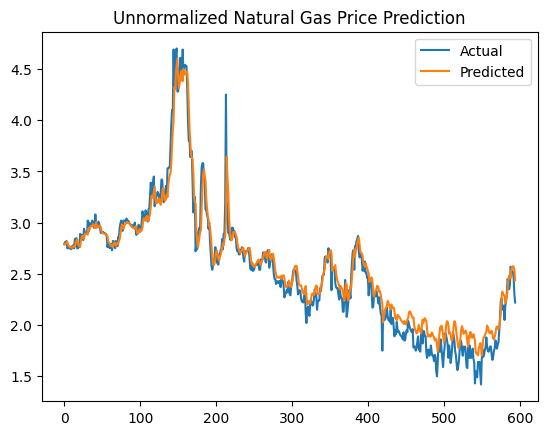

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn

# Step 1: Load and preprocess the data
df = pd.read_csv("./data/archive/daily_csv.csv")

# Drop NA values
df = df.dropna()

# Extract price column
y = df['Price'].values

# Normalize the prices to a range of 0 to 1
minm = y.min()
maxm = y.max()
y = (y - minm) / (maxm - minm)

# Define sequence length (last 10 days to predict the 11th)
Sequence_Length = 10

# Prepare input and output sequences
X = []
Y = []

for i in range(len(y) - Sequence_Length):
    X.append(y[i:i + Sequence_Length])
    Y.append(y[i + Sequence_Length])

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Step 2: Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, shuffle=False)

# Step 3: Define the Dataset class for PyTorch
class NGTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len

# Create Dataset and DataLoader
train_dataset = NGTimeSeries(x_train, y_train)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=256)

# Step 4: Define the RNN Model
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        output, _ = self.rnn(x)
        output = output[:, -1, :]  # Get the last output of the sequence
        output = self.fc1(torch.relu(output))
        return output

# Instantiate the model
model = RNNModel()

# Step 5: Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Step 6: Train the model
epochs = 500

for epoch in range(epochs):
    for data in train_loader:
        inputs, targets = data
        inputs = inputs.view(-1, Sequence_Length, 1)  # Reshape inputs for RNN (batch_size, seq_len, input_size)
        optimizer.zero_grad()
        y_pred = model(inputs).view(-1)
        loss = criterion(y_pred, targets)
        loss.backward()
        optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")

# Step 7: Evaluate the model on the test set
test_dataset = NGTimeSeries(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()  # Set model to evaluation mode

test_pred = []
test_actual = []

with torch.no_grad():
    for data in test_loader:
        inputs, targets = data
        inputs = inputs.view(-1, Sequence_Length, 1)
        y_pred = model(inputs).view(-1)
        test_pred.append(y_pred.item())
        test_actual.append(targets.item())

# Convert lists to arrays for plotting
test_pred = np.array(test_pred)
test_actual = np.array(test_actual)

# Step 8: Plot actual vs predicted prices
plt.plot(test_pred, label='Predicted')
plt.plot(test_actual, label='Actual')
plt.legend()
plt.title('Natural Gas Price Prediction: Actual vs Predicted')
plt.show()

# Step 9: Undo normalization for final results
test_pred_unnormalized = test_pred * (maxm - minm) + minm
test_actual_unnormalized = test_actual * (maxm - minm) + minm

# Plot the unnormalized prices
plt.plot(test_actual_unnormalized, label='Actual')
plt.plot(test_pred_unnormalized, label='Predicted')
plt.legend()
plt.title('Unnormalized Natural Gas Price Prediction')
plt.show()

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import unicodedata
import string
import random

# Character set
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Helper function to convert Unicode to ASCII
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if c in all_letters
    )

# Read data
def load_data():
    category_lines = {}
    all_categories = []
    file_path = "data/data/eng-fra.txt"
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Dataset file {file_path} not found!")
    
    with open(file_path, encoding='utf-8') as f:
        lines = f.read().strip().split("\n")
    
    for line in lines:
        parts = line.split("\t")  # Handling tab separation
        if len(parts) == 2:
            category, name = parts
            category = unicode_to_ascii(category)
            name = unicode_to_ascii(name)
            if category not in category_lines:
                category_lines[category] = []
                all_categories.append(category)
            category_lines[category].append(name)
    
    return category_lines, all_categories

category_lines, all_categories = load_data()
n_categories = len(all_categories)

# Convert names to tensors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][all_letters.index(letter)] = 1
    return tensor

# Define RNN Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

# Training
criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr=0.005)

def random_training_example():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

def train(category_tensor, line_tensor):
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

# Training loop
n_iters = 1000
for iter in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train(category_tensor, line_tensor)
    
    if iter % 100 == 0:
        print(f'Iteration {iter}, Loss: {loss:.4f}')

# Prediction
def predict(input_line):
    with torch.no_grad():
        hidden = rnn.init_hidden()
        line_tensor = line_to_tensor(input_line)
        
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        top_v, top_i = output.topk(1)
        category_index = top_i[0].item()
        return all_categories[category_index]

# Example usage
print(predict("Satoshi"))

Iteration 0, Loss: 11.3178
Iteration 100, Loss: 11.4811
Iteration 200, Loss: 11.4063
Iteration 300, Loss: 11.6021
Iteration 400, Loss: 11.5616
Iteration 500, Loss: 11.4116
Iteration 600, Loss: 11.3497
Iteration 700, Loss: 11.3752
Iteration 800, Loss: 11.4814
Iteration 900, Loss: 11.5277
I've got a good idea.


In [15]:
import re

def parse_translation_file(file_path):
    translations = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = re.split(r'\s{2,}|\t', line, maxsplit=1)  # Split by two or more spaces or a tab
            if len(parts) == 2:
                translations.append((parts[0], parts[1]))
            else:
                print(f"Skipping malformed line: {line}")  # Debugging
    return translations

# Example usage
file_path = "data/data/eng-fra.txt"
parsed_data = parse_translation_file(file_path)
print(parsed_data[300:400])  # Print first 10 translations


[("I'm ugly.", 'Je suis laid.'), ("I'm ugly.", 'Je suis laide.'), ("I'm weak.", 'Je suis faible.'), ("I'm well.", 'Je vais bien.'), ("I'm well.", 'Je me porte bien.'), ("I've won.", "J'ai gagné."), ("I've won.", "Je l'ai emporté."), ('It works.', 'Elle marche.'), ('It works.', 'Ça fonctionne.'), ("It's his.", "C'est le sien."), ("It's his.", "C'est la sienne."), ("It's new.", "C'est nouveau."), ("It's new.", "C'est neuf."), ("It's odd.", "C'est bizarre."), ("It's sad.", 'C’est triste.'), ('Keep out!', "Défense d'entrer."), ('Keep out.', "N'entrez pas."), ('Leave it.', 'Laisse tomber !'), ('Leave it.', 'Laissez tomber !'), ('Leave me.', 'Laissez-moi !'), ('Leave us.', 'Laisse-nous !'), ('Leave us.', 'Laissez-nous !'), ("Let's go!", 'Allons-y !'), ("Let's go!", 'Allons !'), ("Let's go.", 'Allons-y !'), ('Look out!', 'Attention !'), ('Marry me.', 'Épouse-moi !'), ('Marry me.', 'Épousez-moi !'), ('May I go?', 'Puis-je partir ?'), ('May I go?', 'Puis-je y aller ?'), ('May I go?', "Puis-je m

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import unicodedata
import string
import random

# Character set
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Helper function to convert Unicode to ASCII
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if c in all_letters
    )

# Define RNN Model for Next Character Prediction
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Initialize model
n_hidden = 128
char_rnn = CharRNN(n_letters, n_hidden, n_letters)

# Convert character to tensor
def char_to_tensor(char):
    tensor = torch.zeros(1, n_letters)
    tensor[0][all_letters.index(char)] = 1
    return tensor  # Remove extra unsqueeze

# Convert line to tensor
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][all_letters.index(letter)] = 1
    return tensor

# Training setup
criterion = nn.NLLLoss()
optimizer = optim.SGD(char_rnn.parameters(), lr=0.005)

def train(input_line_tensor, target_line_tensor):
    hidden = char_rnn.init_hidden()
    optimizer.zero_grad()
    
    loss = 0
    for i in range(input_line_tensor.size(0)):
        output, hidden = char_rnn(input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i].unsqueeze(0))
    
    loss.backward()
    optimizer.step()
    return loss.item() / input_line_tensor.size(0)

# Training loop
n_iters = 50000
data = ["hello", "world", "python", "torch", "character", 'type']
for iter in range(n_iters):
    word = random.choice(data)
    input_tensor = line_to_tensor(word[:-1])
    target_tensor = torch.tensor([all_letters.index(c) for c in word[1:]], dtype=torch.long)
    loss = train(input_tensor, target_tensor)
    
    if iter % 5000 == 0:
        print(f'Iteration {iter}, Loss: {loss:.4f}')

# Predict next character
def predict_next(input_char, hidden):
    input_tensor = char_to_tensor(input_char)  # No need to unsqueeze
    output, hidden = char_rnn(input_tensor, hidden)
    top_v, top_i = output.topk(1)
    predicted_index = top_i[0].item()
    return all_letters[predicted_index], hidden

# Generate a sequence
def generate(start_char, length=10):
    hidden = char_rnn.init_hidden()
    output_str = start_char
    
    for _ in range(length):
        next_char, hidden = predict_next(output_str[-1], hidden)
        output_str += next_char
    
    return output_str

# Example usage
print(generate("to"))


Iteration 0, Loss: 4.0199
Iteration 5000, Loss: 0.2512
Iteration 10000, Loss: 0.0194
Iteration 15000, Loss: 0.0253
Iteration 20000, Loss: 0.0175
Iteration 25000, Loss: 0.0137
Iteration 30000, Loss: 0.0053
Iteration 35000, Loss: 0.0066
Iteration 40000, Loss: 0.0081
Iteration 45000, Loss: 0.0042
toylhonrrlcn
